<a href="https://colab.research.google.com/github/yurityger/ma_sales/blob/python/sales_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача: провести детальну аналітику та візуалізувати результати продажів в розрізі різних метрик, включаючи географію та різни групи користувачів

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import kruskal


In [ ]:
# підключимось до датасету з Bigquery
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery

project_id = 'data-analytics-mate'
client = bigquery.Client(project=project_id)



---


На основі таблиць, наявних у базі даних, напишемо запит у Python щоб створити датасет, який містить такі поля:

* дата замовлення
* ідентифікатор сесії
* континент
* країна
* девайс
* браузер
* назва моделі пристрою
* операційна система
* мова браузера
* інформація про джерело трафіку
* канал трафіку
* ідентифікатор зареєстрованого користувача
* чи підтвердив користувач свій email
* чи підписався користувач на розсилку
* категорія товару
* назва товару
* ціна
* короткий опис товару


In [ ]:
# перевірка
query = """
SELECT
s.date date,
s.ga_session_id id,
sp.continent continent,
sp.country country,
sp.device device,
sp.browser browser,
sp.mobile_model_name model,
sp.operating_system system,
sp.language language,
sp.name traffic_info,
sp.channel channel,
ac.id account_id,
ac.is_verified verification,
ac.is_unsubscribed unsubscription,
p.category category,
p.name product_name,
p.price price,
p.short_description description

FROM `DA.order` o
join `DA.session` s
on s.ga_session_id = o.ga_session_id
join `DA.session_params` sp
on sp.ga_session_id = s.ga_session_id
left join `DA.account_session` acs
on acs.ga_session_id = s.ga_session_id
left join `DA.account` ac
on acs.account_id = ac.id
join `DA.product` p
on p.item_id = o.item_id

"""
df = client.query(query).to_dataframe()
df.head()

,date,id,continent,country,device,browser,model,system,language,traffic_info,channel,account_id,verification,unsubscription,category,product_name,price,description
0,2020-12-24,5726438444,(not set),(not set),desktop,Chrome,Chrome,Web,None,(referral),Paid Search,<NA>,<NA>,<NA>,Cabinets & cupboards,LIXHULT,356.0,"Wall-mounted cabinet combination, 50x25x50 cm"
1,2020-12-13,5614986004,(not set),(not set),desktop,<Other>,<Other>,Web,en-ca,(organic),Organic Search,<NA>,<NA>,<NA>,Tables & desks,BEKANT,1325.0,"Desk, 140x60 cm"
2,2020-11-05,8542454082,(not set),(not set),desktop,Chrome,Safari,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Chairs,ANTILOP,20.0,Cover
3,2020-12-16,1717992506,(not set),(not set),mobile,Safari,iPhone,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Beds,SUNDVIK,849.0,"Ext bed frame with slatted bed base, 80x200 cm"
4,2021-01-16,8416141289,(not set),(not set),desktop,Chrome,Safari,Web,en-gb,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,ALGOT,130.0,"Wall upright/drying rack, 66x41x197 cm"



Зробимо короткий опис отриманого датасету:
* загальна кількість колонок - **17**
* кількість колонок числового типу (та які саме) - **5 (id, account_id, verification, unsubscription, price**
* кількість колонок категоріального типу (та які саме) - **12 (country, device, browser, model, system, language, traffic_info, channel, category, product_name, descriprion**
* кількість колонок типу datetime - **1 (date)**
* кількість унікальних сесій - **33538**
* який період часу розглядається (від… до…) - **від 2020-11-01 до 2021-01-27**
* чи є пропущені значення - **так, в колонках language, account_id, verification, unsubscription**
* в яких колонках більше пропущених значень, яка причина? - **в колонках language, account_id, verification бо це були сесії гостьових акаунтів**
* яка персент замовлень авторизованих користувачсів? - **8,29%**
* загальна кількість вартість товарів? - **31 971 731.1**


---



In [ ]:
# df.info()
# df.describe()
# print(df['date'].min())
# print(df['date'].max())
# print(df['id'].nunique())
# print(df.isna().sum())
# print(df['account_id'].nunique() / df['id'].nunique() * 100)
# print(df['price'].sum())




---

Визначимо, на яких континентах (топ-3) та в яких країнах (топ-5) компанія має найбільші продажі? найбільшу кількість замовлень?

In [ ]:
revenue_countries = df.groupby('country')["price"].sum().reset_index() # сумарні прибутки по країнах
sorted_revenue_countries = revenue_countries.sort_values(by="price")

sells_countries = df.groupby('country').size().reset_index(name='sales') # сумарні продажі по країнах
sorted_sells_countries = sells_countries.sort_values(by='sales')

# print(sorted_revenue_countries)
# print(sorted_sells_countries)

revenue_countinent = df.groupby('continent')["price"].sum().reset_index() # сумарні прибутки по континентах
sorted_revenue_countinent= revenue_countinent.sort_values(by="price")

sells_countinent = df.groupby('continent').size().reset_index(name='sales') # сумарні продажі по континентах
sorted_sells_countries = sells_countinent.sort_values(by='sales')

# print(sorted_revenue_countinent)
# print(sorted_sells_countries)

**Лідерами по прибутку серед країн є:**
5.  France    710692.8
4. United Kingdom    938317.9
3. Canada   2437921.0
2. India   2809762.0
1. United States  13943553.9


**Лідери по кількості продажів:**
5. France    678
4. United Kingdom   1029
3. Canada   2560
2. India   3029
1. United States  14673


---


**Перелік континентів по прибуткам:**
3. Europe   5934624.2
2. Asia   7601298.3
1. Americas  17665280.0

**Континенти по кількості продажів:**
3. Europe   6261
2. Asia   7950
3. Americas  18553


---





---

Знайдемо топ-10 категорій товарів за загальною сумою продажів

In [ ]:
top_category = df.groupby('category')["price"].sum().reset_index() # сумарні продажі по континентах
sorted_top_category = top_category.sort_values(by='price', ascending=False)
sorted_top_category.head(10)

,category,price
12,Sofas & armchairs,8388254.5
5,Chairs,6147748.8
1,Beds,4919725.0
2,Bookcases & shelving units,3640818.1
3,Cabinets & cupboards,2336499.5
9,Outdoor furniture,2142222.2
13,Tables & desks,1790307.5
6,Chests of drawers & drawer units,906562.5
0,Bar furniture,735503.0
7,Children's furniture,467697.0




---

Знайдемо топ-10 категорій товарів у країні з найбільшими продажами, чи відрізняється ситуація від загальної?

In [ ]:
# відфільтруємо продажи в США
revenue_usa = df[df['country'] == 'United States']
category_revenue_usa = revenue_usa.groupby("category")["price"].sum().reset_index()
sorted_revenue_usa = category_revenue_usa.sort_values(by='price', ascending=False)
sorted_revenue_usa.head(10)

,category,price
12,Sofas & armchairs,3707144.5
5,Chairs,2619773.8
1,Beds,2213058.0
2,Bookcases & shelving units,1567606.9
3,Cabinets & cupboards,994545.5
9,Outdoor furniture,929245.2
13,Tables & desks,777865.0
6,Chests of drawers & drawer units,382388.0
0,Bar furniture,330805.0
7,Children's furniture,207575.0


Дохідність по категоріям товарів товарів в США співпадає з загальними продажами. Це може бути пов'язано з великим відсотком продажі в США


---





---

Проаналізуємо продажі у розрізі типів та моделей девайсів (у % від загальних продажів)

In [ ]:
# спочатку підсумуємо загальні продажі
total_profit = df["price"].sum()

# теперь згрупуємо продажі по типам девайсів
device_revenue = df.groupby("device")["price"].sum().reset_index()
# визначаємо відсоток
device_revenue["percentage"] = ((device_revenue["price"] / total_profit) * 100).round(2)

# групуємо по моделям девайсів
model_revenue = df.groupby("model")["price"].sum().reset_index()
model_revenue["percentage"] = ((model_revenue["price"] / total_profit) * 100).round(2)

# проаналізуємо продажі за джерелами трафіку (у % від загальних продажів)
channel_revenue = df.groupby("channel")["price"].sum().reset_index()
channel_revenue["percentage"] = ((model_revenue["price"] / total_profit) * 100).round(2)


print(f"Дохід по типам девайсів розподілений наступним чином:\n{device_revenue}\n\nПО моделям:\n{model_revenue}\n\nПО каналам трафіку:\n{channel_revenue}")

Дохід по типам девайсів розподілений наступним чином:
    device       price  percentage
0  desktop  18864039.0       59.00
1   mobile  12384225.8       38.73
2   tablet    723466.3        2.26

ПО моделям:
        model      price  percentage
0     <Other>  6535330.8       20.44
1      Chrome  8899523.9       27.84
2  ChromeBook  1830458.7        5.73
3        Edge   697222.3        2.18
4     Firefox   421066.9        1.32
5     Pixel 3   109148.2        0.34
6  Pixel 4 XL   118287.7        0.37
7      Safari  6491062.1       20.30
8        iPad   448854.2        1.40
9      iPhone  6420776.3       20.08

ПО каналам трафіку:
          channel       price  percentage
0          Direct   7494923.4       20.44
1  Organic Search  11433151.6       27.84
2     Paid Search   8511049.4        5.73
3   Social Search   2532105.7        2.18
4       Undefined   2000501.0        1.32




---

Підрахуємо який відсоток зареєстрованих користувачів підтвердив свою електронну адресу та який відсоток зареєстрованих користувачів відписався від розсилки?

In [ ]:
# який відсоток зареєстрованих користувачів підтвердив свою електронну адресу?
# просумуємо кількість користувачів, у кого є accound_id
total_users = df["account_id"].nunique()
# тепер тих, хто підтвердив пошту
confirmed_users = df["verification"].sum()
# рахуємо відсоток
confirmed_percent = ((confirmed_users / total_users) * 100).round(2)
print(f"{confirmed_percent}% користувачів підтвердили свою електрону пошту")

71.52% користувачів підтвердили свою електрону пошту


In [ ]:
unsubscribed_users = df["unsubscription"].sum()
# рахуємо відсоток
unsubscribed_percent = ((unsubscribed_users / total_users) * 100).round(2)
print(f"{unsubscribed_percent}% користувачів відписались від розсилки")

16.07% користувачів відписались від розсилки




---


Подивимось, чи відрізняється поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний?

In [ ]:
# Порівняємо кількість покупок і дохідність обох груп
subscribe_revenue = df.groupby("unsubscription")["price"].sum().reset_index()

subscribe_sells = df.groupby('unsubscription').size().reset_index(name='sales')

print(subscribe_revenue)
print(subscribe_sells)

   unsubscription      price
0               0  2150796.9
1               1   431721.6
   unsubscription  sales
0               0   2334
1               1    447


Отже бачимо, що продажі і дохідність в підписаних користувачі значно вище (в 4-5 разів)


---





---


Підрахуємо і зробимо візуалізацію з розподілом по категоріям відсотка замовлень верифікованих користувачів

In [ ]:
# Створим DataFrame да у нас буде категорія, замовлення та інформація чи зареєстрований користувач
result = {
    "category": df["category"],
    "order": df["id"],
    "verification": df["verification"]
}

cdf = pd.DataFrame(result)

grouped_cdf = cdf.groupby("category").agg(
    order_count=("order", "count"),
    verification_sum=("verification", "sum")
).reset_index()

# Додамо відсоток верифікованих користувачів
grouped_cdf["verification_percent"] = (grouped_cdf["verification_sum"] / grouped_cdf["order_count"]  * 100).round(2)
sorted_cdf = grouped_cdf.sort_values(by="verification_percent")
sorted_cdf.head()

,category,order_count,verification_sum,verification_percent
8,Nursery furniture,394,19,4.82
13,Tables & desks,2941,157,5.34
6,Chests of drawers & drawer units,1452,79,5.44
9,Outdoor furniture,2229,127,5.7
12,Sofas & armchairs,4301,250,5.81


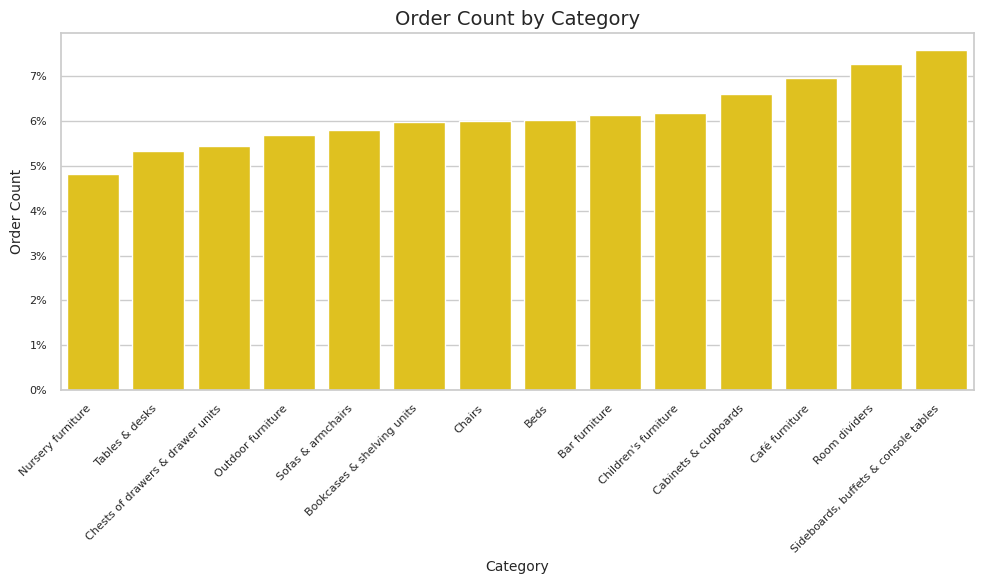

In [ ]:
# Робимо візуалізацію
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bar_chart = sns.barplot(
    x="category", y="verification_percent", data=sorted_cdf, color="Gold"
)
bar_chart.set_title("Order Count by Category", fontsize=14)
bar_chart.set_xlabel("Category", fontsize=10)
bar_chart.set_ylabel("Order Count", fontsize=10)

plt.xticks(rotation=45, ha='right', fontsize=8)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100, decimals=0))
plt.yticks(fontsize=8)

# Показати графік
plt.tight_layout()
plt.show()




---

# **Аналіз динаміки продажів.**

Знайдемо загальні продажі за кожну дату та створимо візуалізацію загальної динаміки продажів

In [ ]:
# Групуємо прибуток по даті
date_revenue = df.groupby("date")["price"].sum().reset_index()
# print(date_revenue)

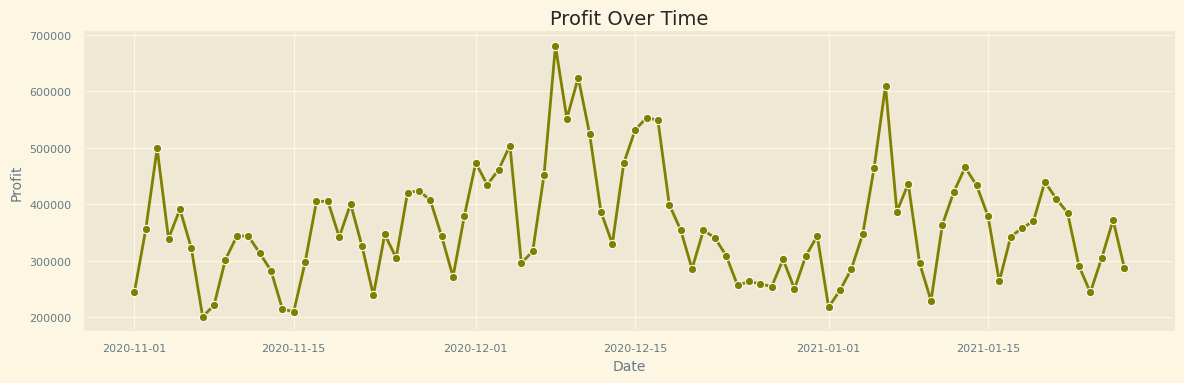

In [ ]:
# Будуємо діаграму
plt.style.use("Solarize_Light2")

plt.figure(figsize=(12, 4))
line_plot = sns.lineplot(x="date", y="price", data=date_revenue, marker="o", color="Olive")

# Налаштування заголовка та підписів
line_plot.set_title("Profit Over Time", fontsize=14)
line_plot.set_xlabel("Date", fontsize=10)
line_plot.set_ylabel("Profit", fontsize=10)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Показати графік
plt.tight_layout()
plt.show()

Зростання та падіння продажів стабільно змінюють один одного раз кожні 7 днів
Продажі зростають г середині грудня і спадають аж до кінця новорічних свят


---





---

Проаналізуємо динаміку продажів в Америці, Азії та Європі.

In [ ]:
world_date_revenue = df.groupby(["continent", "date"])["price"].sum().reset_index()
# Відфільтруємо потрібні континенти
continent_date_revenue = world_date_revenue.loc[
    world_date_revenue["continent"].isin(["Asia", "Europe", "Americas"])]
# print(continent_date_revenue)

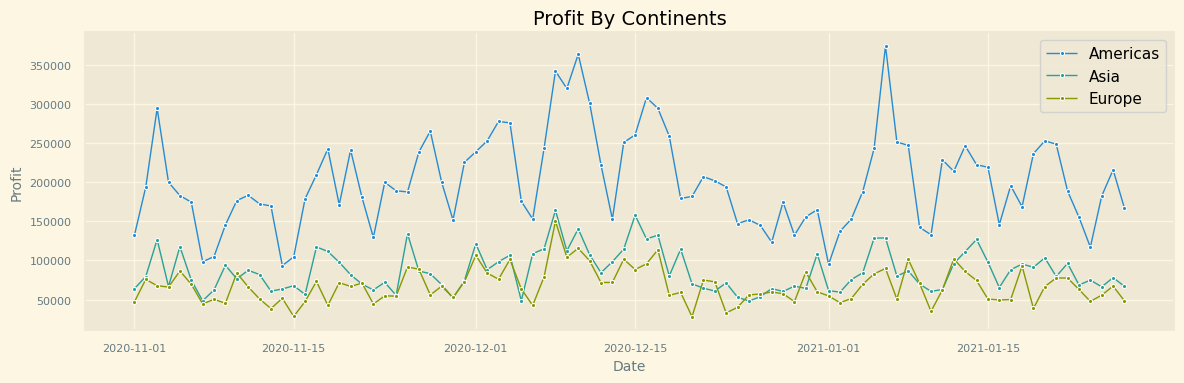

In [ ]:
# Будуємо діаграму
plt.style.use("Solarize_Light2")

plt.figure(figsize=(12, 4))
line_plot = sns.lineplot(x="date", y="price", data=continent_date_revenue, marker="o", hue="continent", linewidth=1, markersize=3)

# Налаштування заголовка та підписів
line_plot.set_title("Profit By Continents", fontsize=14, color="black")
line_plot.set_xlabel("Date", fontsize=10)
line_plot.set_ylabel("Profit", fontsize=10)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

legend = line_plot.legend()
for text in legend.texts:
    text.set_color("black")

plt.tight_layout()

plt.show()



---

Проаналізуємо динаміку продажів у розрізі каналів трафіку

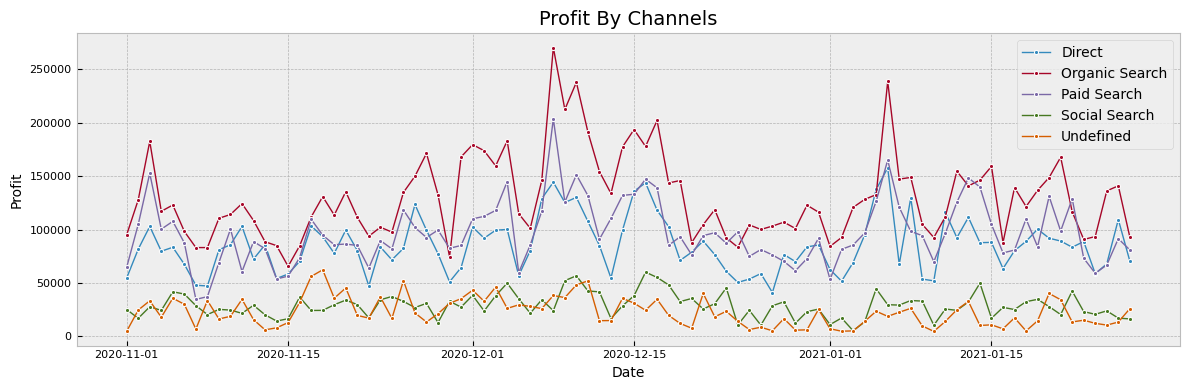

In [ ]:
channel_date_revenue = df.groupby(["channel", "date"])["price"].sum().reset_index()

# Будуємо діаграму
plt.style.use("default")
plt.style.use("bmh")

plt.figure(figsize=(12, 4))
line_plot = sns.lineplot(x="date", y="price", data=channel_date_revenue, marker="o", hue="channel", color="Olive", linewidth=1, markersize=3)

# Налаштування заголовка та підписів
line_plot.set_title("Profit By Channels", fontsize=14)
line_plot.set_xlabel("Date", fontsize=10)
line_plot.set_ylabel("Profit", fontsize=10)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

legend = line_plot.legend()
for text in legend.texts:
    text.set_color("black")

plt.tight_layout()

plt.show()



---

Проаналізуємо динаміку продажів у розрізі типів девайсів

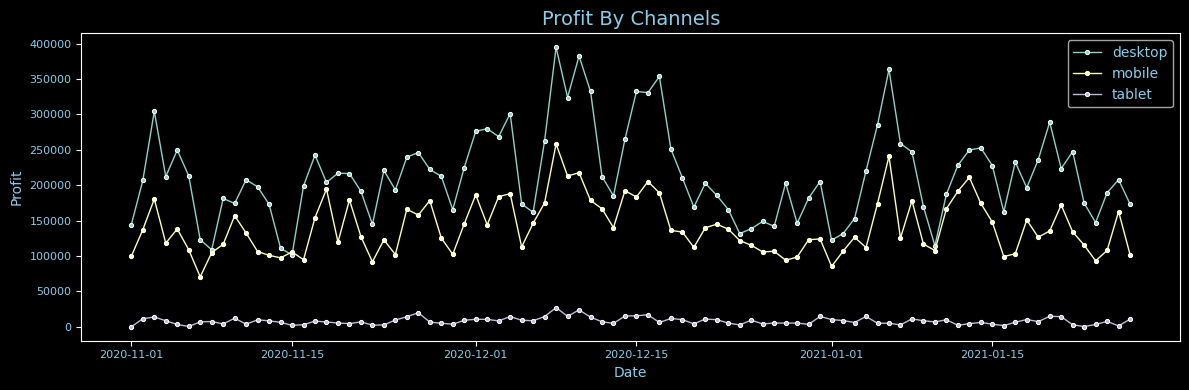

In [ ]:
device_date_revenue = df.groupby(["device", "date"])["price"].sum().reset_index()

# Будуємо діаграму
plt.style.use("default")
plt.style.use("dark_background")

plt.figure(figsize=(12, 4))
line_plot = sns.lineplot(x="date", y="price", data=device_date_revenue, marker="o", hue="device", color="Olive", linewidth=1, markersize=3)

# Налаштування заголовка та підписів
line_plot.set_title("Profit By Channels", fontsize=14, color="skyblue")
line_plot.set_xlabel("Date", fontsize=10, color="skyblue")
line_plot.set_ylabel("Profit", fontsize=10, color="skyblue")

plt.yticks(fontsize=8, color="skyblue")
plt.xticks(fontsize=8, color="skyblue")

legend = line_plot.legend()
for text in legend.texts:
    text.set_color("skyblue")

plt.tight_layout()

plt.show()

Підсумки:
*  Лідер серед депвайсів - desktop;
*  Лідер серед каналів пошуку - organic, трохи відстають paid та direct;
*  Лідер серед депвайсів - desktop;
*  Продажі в Америці вище суми продажів Європи та Азії;


---





---


# **Зведені таблиці**


Створимо зведену таблицю, яка показує кількість сесій у розрізі каналів трафіку та типів девайсів (якщо значення якогось поля невідоме, його не враховуємо)

In [ ]:
device_channel = df.dropna(subset=["channel", "device"]).pivot_table(
    index="channel",
    columns="device",
    aggfunc="size",
    fill_value=0
)

# print(device_channel)



---


Cтворимо зведену таблицю, яка показує загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

In [ ]:
# Зберемо топ категорій та країн
top_categories = df["category"].value_counts().head(10).index
top_countries = df["country"].value_counts().head(5).index

filtered_df = df[df["category"].isin(top_categories) & df["country"].isin(top_countries)]

category_country = filtered_df.pivot_table (
    index="category",
    columns="country",
    values="price",
    aggfunc="sum",
    fill_value=0
)

# print(category_country)



---

Cтворимо таблицю сесій по континентам та операційної системою

In [ ]:
continent_browser = df.dropna(subset=["continent", "system"]).pivot_table(
    index="continent",
    columns="system",
    aggfunc="size",
    fill_value=0
)

print(continent_browser)

system     <Other>  Android  Macintosh    Web  Windows   iOS
continent                                                   
(not set)        3        0          8     41       10     9
Africa           3       33         25    186       42    50
Americas       503     1586       1419  10738     2197  2110
Asia           201      669        614   4695      898   873
Europe         163      530        481   3654      707   726
Oceania          9       34         26    223       42    30




---

**Статистичний аналіз взаємозв’язків.**

Знайдемо кількість сесій та загальні продажі за кожну дату. Створимо візуалізацію, щоб побачити взаємозв’язок між цими метриками. Подивимось, чи корелюють ці показники? Знайдемо відповідний коефіцієнт кореляції та проаналізуємо його статистичну значущість.

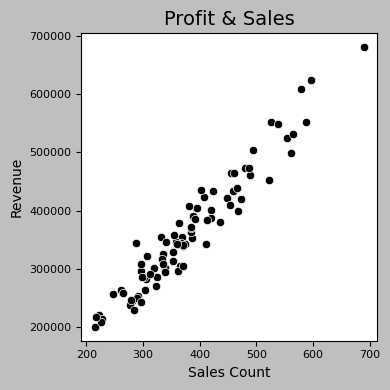

In [ ]:
# Згрупували необхідні нам метрики
day_metrics = df.groupby("date").agg(
    sales_count=("id", "count"),
    revenue=("price", "sum")
).reset_index()

# Будуємо тепер графік
plt.style.use("grayscale")

fig = plt.subplots(figsize=(4, 4))

line_plot = sns.scatterplot(x="sales_count", y="revenue", data=day_metrics)

line_plot.set_title("Profit & Sales", fontsize=14)
line_plot.set_xlabel("Sales Count", fontsize=10)
line_plot.set_ylabel("Revenue", fontsize=10)

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

plt.tight_layout()

plt.show()

Згідно графіку показники корелюються. Прибуток напряму залежить від кількості продажі. Проведемо необхідні тести, щоб це перевірити

In [ ]:
# Проведемо тест Пірсона
correlation, p_value = stats.pearsonr(day_metrics['sales_count'], day_metrics['revenue'])

print(f"Коефіцієнт кореляції Пірсона: {correlation}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("Кореляція статистично значуща.")
else:
    print("Кореляція не статистично значуща.")

Коефіцієнт кореляції Пірсона: 0.9642422533124871
P-value: 2.2447783149167257e-51
Кореляція статистично значуща.




---

Подивимось, чи корелюють між собою продажі на різних континентах? Візьмемо топ-3 континенти. Проаналізуємо статистичну значущість взаємозв’язків.

In [ ]:
# визначимо континенти за продажами
top_continent = df["continent"].value_counts().head(3).index
filtered_continent = df[df["continent"].isin(top_continent)]

# Згрупували необхідні нам метрики
continent_day_revenue = filtered_continent.groupby(["continent", "date"]).agg(
    sales_count=("id", "count"),
    revenue=("price", "sum")
).reset_index()

# Створимо згруповану таблицю
continent_revenue = continent_day_revenue.pivot(index="date", columns="continent", values="revenue").fillna(0)

# Будуємо матрицю кореляції
continent_matrix = continent_revenue.corr()

# Виведення кореляційної матриці
print(continent_matrix)

continent  Americas      Asia    Europe
continent                              
Americas   1.000000  0.692273  0.669527
Asia       0.692273  1.000000  0.667786
Europe     0.669527  0.667786  1.000000


In [ ]:
# Проводимо тест Пірсона для перевірки статиcтичної значимості
for first_continent in continent_matrix.columns:
  for second_continent in continent_matrix.columns:
    if first_continent != second_continent:
      corr, p_value = stats.pearsonr(continent_revenue[first_continent], continent_revenue[second_continent])
      print(f"Кореляція між {first_continent} і {second_continent}: {corr.round(3)}, p-value: {p_value.round(3)}")

Кореляція між Americas і Asia: 0.692, p-value: 0.0
Кореляція між Americas і Europe: 0.67, p-value: 0.0
Кореляція між Asia і Americas: 0.692, p-value: 0.0
Кореляція між Asia і Europe: 0.668, p-value: 0.0
Кореляція між Europe і Americas: 0.67, p-value: 0.0
Кореляція між Europe і Asia: 0.668, p-value: 0.0


У всіх випадках бачимо позитивну кореляцію. P-value значно менше 0,05 а це означає, що всі взаємозв'язки між продажами по континентах статистично значущі.


---





---

Тепер проведемо подібні тести в розрізі каналів трафіку

In [ ]:
# Згрупували необхідні нам метрики
channel_day_revenue = df.groupby(["channel", "date"]).agg(
    sales_count=("id", "count"),
    revenue=("price", "sum")
).reset_index()

# Створимо згруповану таблицю
channel_revenue = channel_day_revenue.pivot(index="date", columns="channel", values="revenue").fillna(0)

# Будуємо матрицю кореляції
channel_matrix = channel_revenue.corr()

# Проводимо тест Пірсона для перевірки статиcтичної значимості
for first_channel in channel_matrix.columns:
  for second_channel in channel_matrix.columns:
    if first_channel != second_channel:
      corr, p_value = stats.pearsonr(channel_revenue[first_channel], channel_revenue[second_channel])
      print(f"Кореляція між {first_channel} і {second_channel}: {corr.round(3)}, p-value: {p_value.round(3)}")

Кореляція між Direct і Organic Search: 0.76, p-value: 0.0
Кореляція між Direct і Paid Search: 0.724, p-value: 0.0
Кореляція між Direct і Social Search: 0.462, p-value: 0.0
Кореляція між Direct і Undefined: 0.424, p-value: 0.0
Кореляція між Organic Search і Direct: 0.76, p-value: 0.0
Кореляція між Organic Search і Paid Search: 0.808, p-value: 0.0
Кореляція між Organic Search і Social Search: 0.434, p-value: 0.0
Кореляція між Organic Search і Undefined: 0.435, p-value: 0.0
Кореляція між Paid Search і Direct: 0.724, p-value: 0.0
Кореляція між Paid Search і Organic Search: 0.808, p-value: 0.0
Кореляція між Paid Search і Social Search: 0.452, p-value: 0.0
Кореляція між Paid Search і Undefined: 0.43, p-value: 0.0
Кореляція між Social Search і Direct: 0.462, p-value: 0.0
Кореляція між Social Search і Organic Search: 0.434, p-value: 0.0
Кореляція між Social Search і Paid Search: 0.452, p-value: 0.0
Кореляція між Social Search і Undefined: 0.359, p-value: 0.001
Кореляція між Undefined і Direct:

Тако ж само у всіх випадках бачимо слабку, помірну або сильну позитивну кореляцію. P-value значно менше 0,05 а це означає, що всі взаємозв'язки між продажами по типам каналів статистично значущі.


---





---

Подивимось ще на результати в розрізі топ 5 категорій

In [ ]:
# визначимо категорії за продажами
top_category = df["category"].value_counts().head(5).index
filtered_category = df[df["category"].isin(top_category)]

# Згрупували необхідні нам метрики
category_day_revenue = filtered_category.groupby(["category", "date"]).agg(
    sales_count=("id", "count"),
    revenue=("price", "sum")
).reset_index()

# Створимо згруповану таблицю
category_revenue = category_day_revenue.pivot(index="date", columns="category", values="revenue").fillna(0)

# Будуємо матрицю кореляції
category_matrix = category_revenue.corr()

# Проводимо тест Пірсона для перевірки статиcтичної значимості
for first_category in category_matrix.columns:
  for second_category in category_matrix.columns:
    if first_category != second_category:
      corr, p_value = stats.pearsonr(category_revenue[first_category], category_revenue[second_category])
      print(f"Кореляція між {first_category} і {second_category}: {corr.round(3)}, p-value: {p_value.round(3)}")

Кореляція між Beds і Bookcases & shelving units: 0.593, p-value: 0.0
Кореляція між Beds і Chairs: 0.554, p-value: 0.0
Кореляція між Beds і Sofas & armchairs: 0.535, p-value: 0.0
Кореляція між Beds і Tables & desks: 0.546, p-value: 0.0
Кореляція між Bookcases & shelving units і Beds: 0.593, p-value: 0.0
Кореляція між Bookcases & shelving units і Chairs: 0.637, p-value: 0.0
Кореляція між Bookcases & shelving units і Sofas & armchairs: 0.666, p-value: 0.0
Кореляція між Bookcases & shelving units і Tables & desks: 0.517, p-value: 0.0
Кореляція між Chairs і Beds: 0.554, p-value: 0.0
Кореляція між Chairs і Bookcases & shelving units: 0.637, p-value: 0.0
Кореляція між Chairs і Sofas & armchairs: 0.578, p-value: 0.0
Кореляція між Chairs і Tables & desks: 0.531, p-value: 0.0
Кореляція між Sofas & armchairs і Beds: 0.535, p-value: 0.0
Кореляція між Sofas & armchairs і Bookcases & shelving units: 0.666, p-value: 0.0
Кореляція між Sofas & armchairs і Chairs: 0.578, p-value: 0.0
Кореляція між Sofas

Тут теж у всіх випадках бачимо слабку, помірну, але завжди позитивну кореляцію. P-value значно менше 0,05 ,всі взаємозв'язки між продажами по категоріям статистично значущі.


---





---

Останнім перевіримо взаємозв'язки між типами OS

In [ ]:
# Згрупували необхідні нам метрики
system_day_revenue = df.groupby(["system", "date"]).agg(
    sales_count=("id", "count"),
    revenue=("price", "sum")
).reset_index()

# Створимо згруповану таблицю
system_revenue = system_day_revenue.pivot(index="date", columns="system", values="revenue").fillna(0)

# Будуємо матрицю кореляції
system_matrix = system_revenue.corr()

# Проводимо тест Пірсона для перевірки статиcтичної значимості
for first_system in system_matrix.columns:
  for second_system in system_matrix.columns:
    if first_system != second_system:
      corr, p_value = stats.pearsonr(system_revenue[first_system], system_revenue[second_system])
      print(f"Кореляція між {first_system} і {second_system}: {corr.round(3)}, p-value: {p_value.round(3)}")

Кореляція між <Other> і Android: 0.144, p-value: 0.18
Кореляція між <Other> і Macintosh: 0.162, p-value: 0.132
Кореляція між <Other> і Web: 0.069, p-value: 0.52
Кореляція між <Other> і Windows: 0.079, p-value: 0.466
Кореляція між <Other> і iOS: 0.093, p-value: 0.389
Кореляція між Android і <Other>: 0.144, p-value: 0.18
Кореляція між Android і Macintosh: 0.341, p-value: 0.001
Кореляція між Android і Web: 0.53, p-value: 0.0
Кореляція між Android і Windows: 0.373, p-value: 0.0
Кореляція між Android і iOS: 0.419, p-value: 0.0
Кореляція між Macintosh і <Other>: 0.162, p-value: 0.132
Кореляція між Macintosh і Android: 0.341, p-value: 0.001
Кореляція між Macintosh і Web: 0.649, p-value: 0.0
Кореляція між Macintosh і Windows: 0.624, p-value: 0.0
Кореляція між Macintosh і iOS: 0.446, p-value: 0.0
Кореляція між Web і <Other>: 0.069, p-value: 0.52
Кореляція між Web і Android: 0.53, p-value: 0.0
Кореляція між Web і Macintosh: 0.649, p-value: 0.0
Кореляція між Web і Windows: 0.706, p-value: 0.0
Кор

В даному випадку у нас все ще усію позитивна кореляція, але є віпадки дуже слабкої. Причиною цього є порівняння з невідомим типом OS (Other), в деяких випадках p-value переважає 0,5


---





---


# Статистичний аналіз відмінностей між групами

Проаналізуємо продажі за кожну дату зареєстрованих та незареєстрованих користувачів. Створимо відповідні вибірки, проаналізуємо розподіли даних в обох вибірках. Підберемо відповідний статистичний тест для порівняння вибірок та зробимо висновок щодо статистичної значущості отриманих результатів.

In [ ]:
# Відфільтруємо і згрупуємо по даті всі продажі зареєстрованих користувачів
accounts = df[df["account_id"].notna()]

grouped_accounts_events = accounts.groupby("date")["price"].sum().reset_index()

# Тепер зберемо замовлення незареєстрованих користувачів

not_accounts = df[df["account_id"].isna()]
grouped_notaccounts_events = not_accounts.groupby("date")["price"].sum().reset_index()

# Проведемо тест обох цих вибірок
t_stat, p_value = ttest_ind(grouped_notaccounts_events["price"], grouped_accounts_events["price"], equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Різниця між вибірками статистично значуща.")
else:
    print("Різниця між вибірками не є статистично значущою.")

T-statistic: 30.5522
P-value: 0.0000
Різниця між вибірками статистично значуща.




---

Проаналізуємо кількість сесій за різними каналами трафіку. Підберемо відповідний тест і подивимось чи є статистично значущі відмінності між групами?

In [ ]:
# Згрупуємо по каналам і підрахуємо кількість тестів, видаливши сесії з невідомим каналом
channels = df.dropna(subset=["channel"])
unique_channel= channels["channel"].unique()

# Cтворимо словник, де у нас будут всі таблиці з каналами
channel_list = {}

for channel in unique_channel:
  if channel.strip() != "Undefined":
    channel_list[channel] = df[df["channel"] == channel]

# Проведемо тести між вибірками
for first_channel in channel_list:
    for second_channel in channel_list:
        if first_channel != second_channel:
            t_stat, p_value = ttest_ind(channel_list[first_channel]["price"], channel_list[second_channel]["price"], equal_var=False)
            if p_value < 0.05:
              print(f"Різниця між вибірками {first_channel} і {second_channel} статистично значуща. P_value = {p_value}")
            else:
              print(f"Різниця між вибірками {first_channel} і {second_channel} не є статистично значущою. P_value = {p_value}")

Різниця між вибірками Paid Search і Organic Search не є статистично значущою. P_value = 0.32963463096390333
Різниця між вибірками Paid Search і Direct не є статистично значущою. P_value = 0.3366431929389536
Різниця між вибірками Paid Search і Social Search не є статистично значущою. P_value = 0.7529094828801534
Різниця між вибірками Organic Search і Paid Search не є статистично значущою. P_value = 0.32963463096390333
Різниця між вибірками Organic Search і Direct не є статистично значущою. P_value = 0.9251810900281588
Різниця між вибірками Organic Search і Social Search не є статистично значущою. P_value = 0.3346034152911732
Різниця між вибірками Direct і Paid Search не є статистично значущою. P_value = 0.3366431929389536
Різниця між вибірками Direct і Organic Search не є статистично значущою. P_value = 0.9251810900281588
Різниця між вибірками Direct і Social Search не є статистично значущою. P_value = 0.3277460106353708
Різниця між вибірками Social Search і Paid Search не є статистично



---

Чи відрізняється статистично доля сесій з органічним трафіком у Європі та Америці? Підбери відповідний тест. Проведи потрібні обчислення для створення вхідних даних до тесту.

In [ ]:
# Зберемо всі сесій з типом трафіку Organic по Європі та Америці
organic_europe = df[(df["channel"] == "Organic Search") & (df["continent"] == "Europe")]
organic_americas = df[(df["channel"] == "Organic Search") & (df["continent"] == "Americas")]

# Проведемо тест порівняння вибірок
t_stat, p_value = ttest_ind(organic_europe["price"], organic_americas["price"], equal_var=False)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("Різниця між вибірками статистично значуща.")
else:
    print("Різниця між вибірками не є статистично значущою.")

T-statistic: -0.0167
P-value: 0.9867
Різниця між вибірками не є статистично значущою.




---

Проведемо Тест Краскала-Уолліса в розрізі девайсів

In [ ]:
unique_device = channels["device"].unique()

# Створимо словник з девайсів
device_list = {device: df[df["device"] == device] for device in unique_device}

# Робимо тест Краскала-Уолліса=
for i, first_device in enumerate(device_list):
    for second_device in list(device_list)[i + 1:]:
        group_1 = device_list[first_device]["price"]
        group_2 = device_list[second_device]["price"]

        h_stat, p_value = kruskal(group_1, group_2)

        if p_value < 0.05:
            print(f"Різниця між вибірками {first_device} і {second_device} статистично значуща. p-value = {p_value:.3f}")
        else:
            print(f"Різниця між вибірками {first_device} і {second_device} не є статистично значущою. p-value = {p_value:.3f}")

Різниця між вибірками desktop і mobile не є статистично значущою. p-value = 0.159
Різниця між вибірками desktop і tablet не є статистично значущою. p-value = 0.192
Різниця між вибірками mobile і tablet не є статистично значущою. p-value = 0.086


In [ ]:
# Збрегаємо головну таблицю
df.to_csv('for_tablue_portfolio_2.csv', index=False)

- Посилання на [візуалізацію](https://public.tableau.com/shared/QBZTGYDXN?:display_count=n&:origin=viz_share_link)
- Посилання на [таблицю](https://docs.google.com/spreadsheets/d/1ovi1ZothDbGIu7wW4buqJRx1DLKD1eFGH6EFrM5oVwU/edit?gid=1075708995#gid=1075708995)